# Module import

In [1]:
from netCDF4 import Dataset                             
import numpy as np                                      
from scipy import ndimage                               
import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
from matplotlib.patches import Rectangle                
from scipy.ndimage import zoom
from skimage.transform import resize
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader
import sys
sys.path.insert(1, "/home/users/mendrika/SSA/SA/module")
import snflics
import warnings
warnings.filterwarnings("ignore")

# Geodata

In [2]:
y_min, y_max = 580, 930
x_min, x_max = 1480, 1850

In [3]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max, x_min:x_max]
lats = geodata["lat"][y_min:y_max, x_min:x_max]

In [4]:
lons.shape

(350, 370)

In [5]:
CONTEXT_LAT_MIN = np.min(lats)
CONTEXT_LAT_MAX = np.max(lats)
CONTEXT_LON_MIN = np.min(lons)
CONTEXT_LON_MAX = np.max(lons)

# Core data

In [6]:
year = "2024"
month = "02"
day = "28"
hour = "21"
minute = "00"

In [7]:
def load_wavelet_dataset(year, month, day, hour, minute):
    path_core = f'/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}'
    file = f'{path_core}/{year}{month}{day}{hour}{minute}.nc'
    return Dataset(file, mode='r')

In [8]:
data = load_wavelet_dataset(year, month, day, hour, minute)

# wavelet power maxima's coordinates
x0_lat = data["max_lat"][:]
x0_lon = data["max_lon"][:]

# cloud top temperature and wavelet power arrays
temp = data["tir"][0, y_min:y_max, x_min:x_max]
cores = data["cores"][0, y_min:y_max, x_min:x_max]
binary_cores = (cores != 0).astype(int)

In [9]:
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

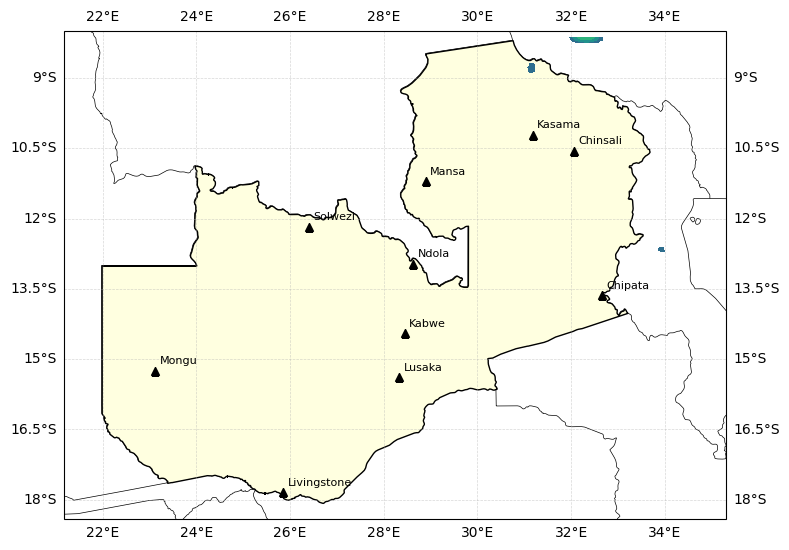

In [10]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
ax.set_extent([CONTEXT_LON_MIN, CONTEXT_LON_MAX, CONTEXT_LAT_MIN, CONTEXT_LAT_MAX], crs=ccrs.PlateCarree())

# Base features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries and extract Zambia only
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural', name=shapename)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor='lightyellow', edgecolor='black', linewidth=1.0, zorder=2)

# Your 10 locations
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

# Plot locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6, transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.1, lat + 0.1, name, fontsize=8, transform=ccrs.PlateCarree(), ha='left', va='bottom', color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', linewidth=0.5)


# Mask zero values (so they become transparent)
cores_masked = np.ma.masked_where(cores == 0, cores)

# Plot wavelet power only where > 0
contour_core = ax.contourf(
    lons, lats, cores_masked,
    levels=[0, 10, 20, 40, 80, 120, 160, 200, 240, 280],  # no 0 level
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    extend="max",
    zorder=2
)

plt.tight_layout()
plt.show()